# Exploring the ICIJ Offshore Leaks database

## Kyle Willett

### 20 Jul 2016

One basic question is to assess the demographics of the companies involved, many of whom fit historical definitions of [tax havens](http://www.investopedia.com/terms/t/taxhaven.asp). In the past, these include countries with small populations, overseas territories, and unstable or non-democratic governments. 

I examined the data in the [Offshore ICIJ database](https://offshoreleaks.icij.org/) to see if the companies involved are associated with countries fitting these characteristics, or whether there's a broader set of locations involved. Matching the address nodes against population and business count identifies a group of roughly a **dozen nations** responsible for a disproportionate fraction of offshore businesses, particularly focusing on small island nations and British overseas dependencies. The **British Virgin Islands** had by far the highest ratio of offshore business to total population. Institutions in these countries should be high-priority candidates for follow-up investigations into illegal offshore activity. 

While processing the data, I also devised a method to better clean the data and merge nodes that were originally designated as separate locations. Using measures of similarity on text processing, **3%** of the address nodes can be merged in the ICIJ database. 

In [1]:
%matplotlib inline

# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Load in data from the Panama Papers ICIJ site (set of CSV files)

addresses = pd.read_csv("Addresses.csv",
                        dtype={'address':str,
                               'icij_id':str,
                               'valid_until':str,
                               'country_codes':str,
                               'countries':str,
                               'node_id':np.int64,
                               'sourceID':str})

Look briefly at structure and content of the `addresses` file.

In [3]:
addresses.head()

,address,icij_id,valid_until,country_codes,countries,node_id,sourceID
0,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,6991059DFFB057DF310B9BF31CC4A0E6,The Panama Papers data is current through 2015,SGP,Singapore,14000001,Panama Papers
1,"""Almaly Village"" v.5, Almaty Kazakhstan",C65A269424AA1A8BBAC416FA30150938,The Panama Papers data is current through 2015,KAZ,Kazakhstan,14000002,Panama Papers
2,"""Cantonia"" South Road St Georges Hill Weybridg...",240EE44DFB70AF775E6CD02AF8CB889B,The Panama Papers data is current through 2015,GBR,United Kingdom,14000003,Panama Papers
3,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",340C6D3D2FC60AE58C53BB3618129C43,The Panama Papers data is current through 2015,GGY,Guernsey,14000004,Panama Papers
4,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",6DBCD74F5AAB63EABC166885CE8CD7CD,The Panama Papers data is current through 2015,KEN,Kenya,14000005,Panama Papers


While the number of addresses and companies at each location can be counted, that doesn't give any context as to whether the smaller countries (with more distinct characteristics) are represented at unusual frequencies. As an initial estimate, we'll compare it to the country's total population (future metrics could include things like GDP, international memberships, numbers of banks, etc). 

In [4]:
# Load 2015 population data from World Bank

popfile = "API_SP.POP.TOTL_DS2_en_csv_v2.csv"
country_name = []
country_code = []
pop_2015 = []
with open(popfile,'r') as f:
    for idx,line in enumerate(f):
        if idx > 5:
            s = line.split(",")
            country_name.append(s[0].strip()[1:-1])
            country_code.append(s[1].strip()[1:-1])
            pop_2015.append(int((s[-2].strip()[1:-1]).split(".")[0]))

Link the two datasets (Panama Papers and population)

In [5]:
# Join the dataframes

dfpop = pd.DataFrame(index=country_code,data={"country_name":country_name,"population":pop_2015})

# Add a new column that counts the number of addresses in each country

counted = addresses.groupby('country_codes').count()['countries']
joined = dfpop.join(counted)
joined.rename(columns = {'countries':'address_count'}, inplace = True)

Now that we have all the data in a single frame, let's look at the results. Start by simply plotting the population against the number of addresses per country. If there's no strong preference toward tax havens, the two values should be strongly correlated. 

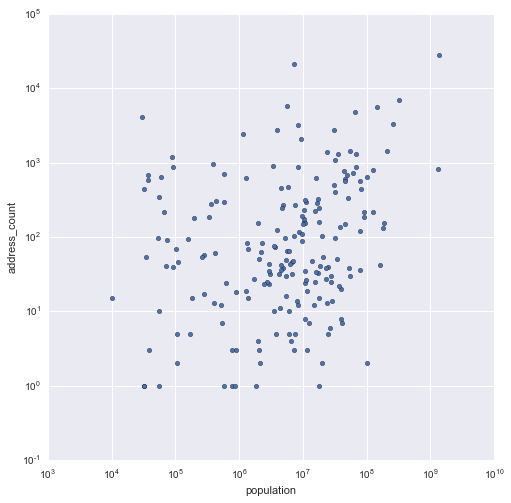

In [6]:
# Plot as a scatter plot

good = np.isfinite(joined.address_count)
joined[good].plot(x='population',y='address_count',
                  kind='scatter',
                  loglog=True,
                  figsize=(8,8));

There's definitely a trend (even within log space), but quite a lot of scatter and outliers. For example, one country in the top 10 for overall address count is in the bottom 5 for population. 

In [7]:
# Check the actual correlation value

joined.corr()

,population,address_count
population,1.000000,0.561871
address_count,0.561871,1.000000


This value (0.561) tells us that the data are mildly correlated, but not with high statistical significance. 

That gives the overall distribution; let's look at the countries dominating the high and low ends of the data. 

In [8]:
print "Countries with the highest number of addresses\n\n",joined.sort_values(
    by="address_count",ascending=False).head()
print ""
print "Countries with the lowest number of addresses\n\n",joined.sort_values(
    by="address_count",ascending=True).head()

Countries with the highest number of addresses

      country_name  population  address_count
CHN          China  1371220000          28073
HKG      Hong Kong     7305700          21041
USA  United States   321418820           6860
SGP      Singapore     5535002           5728
RUS         Russia   144096812           5534

Countries with the lowest number of addresses

                 country_name  population  address_count
MNP  Northern Mariana Islands       55070              1
GNB             Guinea-Bissau     1844325              1
BTN                    Bhutan      774830              1
SMR                San Marino       31781              1
GNQ         Equatorial Guinea      845060              1


So the top five correlate with three of the most populous countries in the world (US, China, Russia) and two smaller countries that are known for being [business and financial capitals](https://en.wikipedia.org/wiki/Four_Asian_Tigers) (Hong Kong, Singapore). The bottom five include a US dependency, two of the smallest countries on the African mainland, a European micronation, and the relatively isolated Asian nation of Bhutan.

So let's clarify the question further, and move away from absolute numbers to a ratio. What are the countries that are **statistically over-represented** in terms of their population to business ratio?

In [9]:
ratio = joined.address_count / joined.population
joined['pop_bus_ratio'] = ratio

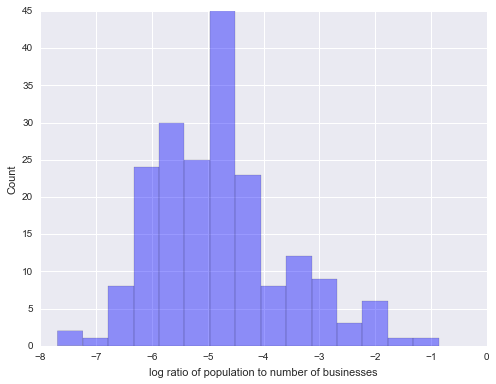

In [10]:
# Plot the results (in log space) as a histogram

fig,ax = plt.subplots(1,1,figsize=(8,6))
p = sns.distplot(np.log10(joined[good].pop_bus_ratio), kde=False, color="b",ax=ax)
p.set_xlabel('log ratio of population to number of businesses')
p.set_ylabel('Count');

So even by eye, there's a clear skew and a long tail to the right of the distribution. The high value here indicates countries with many more addresses/businesses per capita citizen than expected.

In [11]:
# What are the names of these countries?

joined.sort_values("pop_bus_ratio",ascending=False)[:15]

,country_name,population,address_count,pop_bus_ratio
VGB,British Virgin Islands,30117,4125,0.136966
LIE,Liechtenstein,37531,690,0.018385
MCO,Monaco,37731,589,0.015611
GIB,Gibraltar,32217,440,0.013657
IMN,Isle of Man,87780,1171,0.013340
CYM,Cayman Islands,59967,646,0.010773
SYC,Seychelles,92900,871,0.009376
KNA,St. Kitts and Nevis,55572,347,0.006244
BMU,Bermuda,65235,218,0.003342
HKG,Hong Kong,7305700,21041,0.002880


This is more like the definition above; numerous dependencies, lots of micronations and small island countries, and very small average populations overall. 

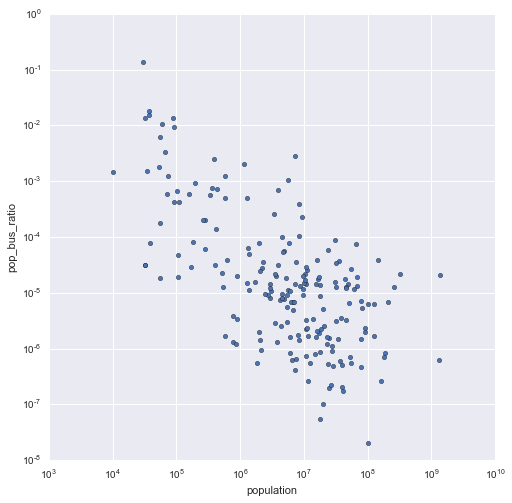

In [12]:
# Plot the total population versus the ratio constructed above.

joined[good].plot(x='population',y='pop_bus_ratio',
                  kind='scatter',
                  loglog=True,
                  figsize=(8,8));

So now the data are separating more clearly. Instead of picking a sample by eye, let's try a clustering algorithm on these features and see if the extremes select a similar set of data.

In [13]:
# Use the k-means clustering algorithm from scikit-learn

from sklearn.cluster import KMeans

n_clusters = 5
X = np.log10(np.array(joined[good][['population','pop_bus_ratio']]))
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)

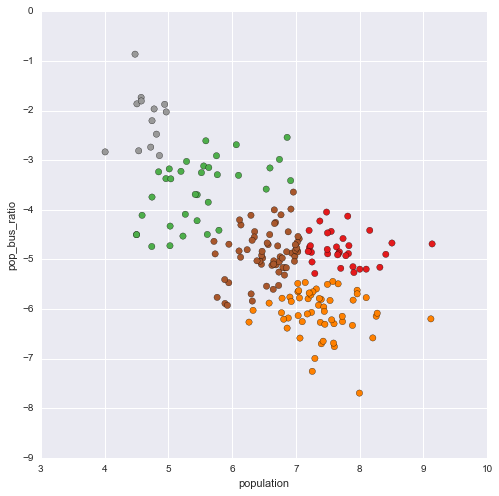

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(111)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,cmap=plt.cm.Set1,s=40)
plt.xlabel('population')
plt.ylabel('pop_bus_ratio');

In [15]:
np.mean(X[y_pred == 1,0])

5.4996211164501014

In [16]:
# Look at the countries corresponding to the top left cluster

cluster_topleft = 0
xmean = max(X[:,0])
for i in range(n_clusters):
    avgpop = np.mean(X[y_pred == i,0])
    if avgpop < xmean:
        xmean = avgpop
        cluster_topleft = i
        
print joined[good][y_pred == cluster_topleft]

                 country_name  population  address_count  pop_bus_ratio
BMU                   Bermuda       65235            218       0.003342
CYM            Cayman Islands       59967            646       0.010773
DMA                  Dominica       72680             90       0.001238
GIB                 Gibraltar       32217            440       0.013657
IMN               Isle of Man       87780           1171       0.013340
KNA       St. Kitts and Nevis       55572            347       0.006244
LIE             Liechtenstein       37531            690       0.018385
MCO                    Monaco       37731            589       0.015611
MHL          Marshall Islands       52993             97       0.001830
NRU                     Nauru       10222             15       0.001467
SYC                Seychelles       92900            871       0.009376
TCA  Turks and Caicos Islands       34339             53       0.001543
VGB    British Virgin Islands       30117           4125       0

Almost uniformly, these are countries with very small populations (< 100,000). 11/14 are small island countries, and 6/14 are dependencies of the United Kingdom (but with different tax and financial status, which presumably strongly affects the likelihood of choosing to incorporate there). The latter category is really over-represented; the [UN List of Non-Self-Governing Territories](https://en.wikipedia.org/wiki/United_Nations_list_of_Non-Self-Governing_Territories) has only 17 total entries, of which 6 appear in this smaller list of 14. The odds of that happening independently are essentially zero ($p\simeq10^{-20}$).   

The (British) Virgin Islands deserve special mention; their average ratio of population to number of addresses is roughly a factor of 10 higher than **any** other country in the database, with 1 Offshore Leaks business for roughly every 7.3 inhabitants. There could be many reasons for this (including geographical proximity to the Mossack Fonseca offices in Panama), but it's a very clear starting point for further investigations into a wide range of companies. 

In [17]:
# Here are the top 15 countries in the list above colored in bright orange on a world map. Spot any?

# Made with https://www.amcharts.com/visited_countries/#MC,LI,IM,GI,KN,TC,VG,BM,DM,KY,SC,MH,NR

from IPython.display import Image
Image(url="http://i.imgur.com/hpgZsx1.png")

In [18]:
# Zooming way into the Caribbean, a few of the entries are finally visible.

Image(url="http://i.imgur.com/dt5anpZ.png")

### Address disambiguation

Iterating a little bit more on the addresses would potentially be very useful; small differences between the strings can point to the same place and cause potential overcounting (or make it difficult to merge records that should point to the same node). 

Can we clean the data any further beyond the original state?

In [19]:
import jellyfish

In [20]:
# Group by country; there shouldn't be any need to compare addresses in different countries,
# since that would be computationally expensive and we assume that would require a large shift
# in the difference between text strings (ie, extremely unlikely to change 1 letter and go from a real address
# in North Korea to one in South Africa).

grouped = addresses.groupby("country_codes")

In [21]:
# As a test case, let's look at addresses in the last country in the group: Zimbabwe.

zw = list(addresses[addresses['country_codes'] == 'ZWE'].address)
print len(zw)

225


In [22]:
dl = []
for idx,z in enumerate(zw):
    for z2 in zw[idx+1:]:
        try:
            dl_ = jellyfish.damerau_levenshtein_distance(unicode(z,'utf-8'),unicode(z2,'utf-8'))
            dl.append(dl_)
        except:
            pass

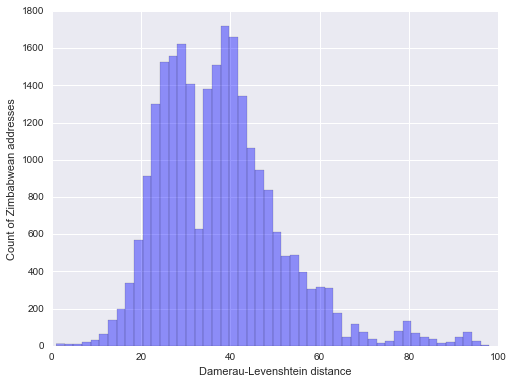

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
p = sns.distplot(dl, kde=False, color="b",ax=ax)
p.set_xlabel('Damerau-Levenshtein distance')
p.set_ylabel('Count of Zimbabwean addresses');

There seems to be a clear peak of duplicates at a D-L distance of only a couple ($<3). Try a couple different sizes and manually evaluate the true positive and true negative rate. 

In [24]:
for n in (1,2,3,4,5):
    print "\n DL <= {}".format(n)
    for idx,z in enumerate(zw):
        for z2 in zw[idx+1:]:
            try:
                dl_ = jellyfish.damerau_levenshtein_distance(unicode(z,'utf-8'),unicode(z2,'utf-8'))
                if dl_ == n:
                    print "{} -> {}".format(z,z2)
                    break
            except:
                pass


 DL <= 1
11 Argyl Drive Highlands Harare Zimbabwe -> 11 Argyll Drive Highlands Harare Zimbabwe
5 CARNARVON ROAD HILLSIDE BULAWAYO ZIMBABWE -> 5 CARNAVON ROAD HILLSIDE BULAWAYO ZIMBABWE
5 CARNAVON ROAD HILLSIDE BULAWAUYO ZIMBABWE -> 5 CARNAVON ROAD HILLSIDE BULAWAYO ZIMBABWE
85 Harare Drive; Northwood; Harare; Zimbabwe -> 85 Harere Drive; Northwood; Harare; Zimbabwe
The Lodge; 24b Arnold Edmunds Drive; Glen Horne; Harare; Zimbabwe -> The Lodge; 24b Arnold Edmunds Drive; Glen Lorne; Harare; Zimbabwe

 DL <= 2
20 Basset Crescent; Alexander Park; Harare; Zimbabwe -> 20 Basset Crescent; Alexandra Park; Harare; Zimbabwe
22 Pevensey Road; Highlands; Harare; Zimbabwe -> 23 Pevensey Road; Highlands; Harare; Zimbawe
5 CARNARVON ROAD HILLSIDE BULAWAYO ZIMBABWE -> 5 CARNAVON ROAD HILLSIDE BULAWAUYO ZIMBABWE
First Floor CABS Building; Northend Close; Northridge Park; Harare; Zimabwe -> First Floor CABS Building; Northend Close; Northridge Park; Harare; Zimbabwe.
Jacobin Investments Limite; 18 Keni

Assess each address pair manually; simple transpositions or errors are a true positive. A situation where the house number changed, though, could be either a transcription error OR two truly different locations on the same street. To be conservative, the latter will be counted as a false positive.

```
DL <= 1: TP = 5, FP = 0
DL <= 2: TP = 9, FP = 1
DL <= 3: TP = 12, FP = 4
DL <= 4: TP = 12, FP = 6
DL <= 5: TP = 17, FP = 7
```

The false positive rate increases sharply at DL <= 3. Acting conservatively, we'll only use a DL-distance of 2 for the sample. 

In [ ]:
# Run algorithm on the entire sample. How many nodes can we merge in the set?

dl_threshold = 2

duplicate_addresses = {}
failed_to_parse = 0
for g in grouped:
    name = g[0]
    print "Processing {}".format(name)
    duplicate_addresses[name] = 0
    lst = list(g[1].address)
    if len(lst) > 1:
        for idx,add1 in enumerate(lst):
            # Don't compare twice and double-count.
            for add2 in lst[idx+1:]:
                try:
                    dl = jellyfish.damerau_levenshtein_distance(unicode(add1,'utf-8'),unicode(add2,'utf-8'))
                    if dl <= dl_threshold:
                        duplicate_addresses[name] += 1
                        break
                except:
                    failed_to_parse += 1

In [26]:
print duplicate_addresses

{'AGO': 3, 'DZA': 0, 'EGY': 5, 'BGD': 0, 'LIE': 71, 'NAM': 1, 'BGR': 0, 'BOL': 0, 'GHA': 1, 'PAK': 9, 'CPV': 1, 'JOR': 17, 'LBR': 5, 'LBY': 1, 'MYS': 71, 'PRI': 0, 'SXM': 0, 'PRK': 0, 'PSE': 1, 'TZA': 1, 'BWA': 2, 'KHM': 0, 'TTO': 0, 'ETH': 0, 'PRY': 0, 'HKG': 575, 'SAU': 21, 'LBN': 17, 'SVN': 1, 'BFA': 0, 'CHE': 123, 'HRV': 0, 'CHL': 2, 'CHN': 439, 'KNA': 40, 'SLE': 0, 'JAM': 1, 'GIB': 60, 'DJI': 0, 'GIN': 0, 'FIN': 0, 'URY': 23, 'THA': 40, 'SYC': 132, 'NPL': 0, 'LAO': 2, 'YEM': 0, 'PHL': 11, 'ZAF': 51, 'NIC': 1, 'ROU': 2, 'VIR': 0, 'SYR': 0, 'MAC': 14, 'MAF': 0, 'MLT': 8, 'KAZ': 1, 'TCA': 4, 'PYF': 0, 'NIU': 1, 'DMA': 7, 'BEN': 0, 'NGA': 0, 'BEL': 9, 'TGO': 0, 'DEU': 6, 'GUM': 0, 'LKA': 1, 'GBR': 148, 'GUY': 0, 'CRI': 5, 'CMR': 0, 'MAR': 0, 'MNP': 0, 'LSO': 1, 'HUN': 6, 'TKM': 0, 'SUR': 0, 'NLD': 7, 'BMU': 15, 'TCD': 1, 'GEO': 3, 'MNE': 3, 'MNG': 2, 'MHL': 10, 'MTQ': 0, 'BLZ': 22, 'MMR': 0, 'NFK': 0, 'VGB': 482, 'BLR': 1, 'GRD': 0, 'GRC': 7, 'AND': 1, 'MOZ': 0, 'TJK': 0, 'HTI': 4, 'M

In [35]:
print "Able to merge {} addresses in system ({:.1f}%).".format(sum(duplicate_addresses.values()),
                                      sum(duplicate_addresses.values())*100./len(addresses))

Able to merge 5006 addresses in system (3.3%).
